In [1]:
import sys
sys.path.append("../Simulations/")

from units import *
import matplotlib.pyplot as plt
from tqdm import *
from scipy.integrate import nquad, quad
from scipy.special import erf, jn, jv, kn
import mpmath as mp

%matplotlib inline
%load_ext autoreload
%autoreload 2

Profiles to code up:
- tNFW
- Burkert


In [54]:
def R0_VL(M0):
    """ Concentration-mass relation from 1711.03554
    """
    return 1.2*kpc*(M0/(1e8*M_s))**0.5

def c200_SC(M200):
    """ Virial concentration according to Sanchez-Conde&Prada14
    """
    x=mp.log(M200*h) # Given in terms of M_s/h in S-C&P paper
    pars=[37.5153, -1.5093, 1.636e-2, 3.66e-4, -2.89237e-5, 5.32e-7][::-1]
    return np.polyval(pars, x)

# def get_rs_rhos_NFW(M200):
#     """ Get NFW scale radius and density
#     """
#     c200 = c200_SC(M200/M_s)
#     del_c = (200/3.)*c200**3/(mp.log(1 + c200) - c200/(1 + c200))
#     rho_s = rho_c*del_c
#     r200 = (M200/(4/3.*mp.pi*200*rho_c))**(1/3.)
#     r_s = r200/c200
#     return r_s, rho_s

def get_rs_rhos_NFW(M200):
    """ Get NFW scale radius and density
    """
    c200 = c200_SC(M200/M_s)
    r200 = (M200/(4/3.*mp.pi*200*rho_c))**(1/3.)
    rho_s = M200/(4*mp.pi*(r200/c200)**3*(mp.log(1 + c200) - c200/(1 + c200)))
    r_s = r200/c200
    return r_s, rho_s

def get_rb_rhob_Burk(M200, p):
    """ Get NFW scale radius and density
    """
    c200n = c200_SC(M200/M_s)
    c200b = c200n/p
    r200 = (M200/(4/3.*mp.pi*200*rho_c))**(1/3.)
    r_b = r200/c200b
    rho_b = M200/(r_b**3*mp.pi*(-2*mp.atan(c200b) + mp.log((1+c200b)**2*(1+c200b**2))))
    return r_b, rho_b

def F(x):
    """ Helper function for NFW deflection, from astro-ph/0102341
    """
    if x > 1:
        return mp.atan(mp.sqrt(x**2-1))/(mp.sqrt(x**2 - 1))
    elif x == 1:
        return 1
    elif x < 1:
        return mp.atanh(mp.sqrt(1-x**2))/(mp.sqrt(1-x**2))
    
def Ft(x, tau):
    return tau**2/(tau**2 + 1)**2*((tau**2 + 1 + 2*(x**2 - 1))*F(x) + tau*mp.pi + (tau**2 - 1)*mp.log(tau) + mp.sqrt(tau**2 + x**2)*(-mp.pi + (tau**2 - 1)/tau*L(x, tau)))

def L(x, tau):
    return mp.log(x/(mp.sqrt(tau**2 + x**2) + tau))

def Fb(x):
    if x > 1:
        return mp.log(x/2.) + mp.pi/4.*(mp.sqrt(x**2 + 1) - 1) + mp.sqrt(x**2 + 1)/2*mp.acoth(mp.sqrt(x**2 + 1)) - 0.5*mp.sqrt(x**2 - 1)*mp.atan(mp.sqrt(x**2 - 1))
    elif x == 1:
        return -mp.log(2.) - mp.pi/4. + 1/(2*mp.sqrt(2))*(mp.pi + mp.log(3 + 2*mp.sqrt(2)))
    elif x < 1:
        return mp.log(x/2.) + mp.pi/4.*(mp.sqrt(x**2 + 1) - 1) + mp.sqrt(x**2 + 1)/2*mp.acoth(mp.sqrt(x**2 + 1)) + 0.5*mp.sqrt(1 - x**2)*mp.atanh(mp.sqrt(1 - x**2))

In [103]:
def MGauss(theta, M0, beta0):
    return M0*(1-mp.exp(-theta**2/(2*beta0**2)))

def MPlumm(theta, M0, beta0):
    return M0*theta**2/(theta**2 + beta0**2)

def MNFW(r, M200):
    r_s, rho_s = get_rs_rhos_NFW(M200)
    x = r/r_s
    M0 = 4*np.pi*r_s**3*rho_s
    phi_r = M0*(mp.log(x/2) + F(x))
    return phi_r/1e69

def MtNFW(r, M200, tau=15):
    r_s, rho_s = get_rs_rhos_NFW(M200)
    x = r/r_s
    M0 = 4*np.pi*r_s**3*rho_s
    phi_r = M0*Ft(x, tau)
    return phi_r/1e69

def MBurk(r, M200, p=0.7):
    r_b, rho_b = get_rb_rhob_Burk(M200, p)
    x = r/r_b
    M0 = 4*np.pi*r_b**3*rho_b
    phi_r = M0*Fb(x)
    return phi_r/1e69

In [56]:
# r_ary = np.linspace(0.01, 10, 100)*kpc
# MNFW_ary = np.array([1e69*MNFW(r, M0) for r in r_ary])/M_s
# MPlumm_ary = np.array([MPlumm(r/Dl, M0, R0/Dl) for r in r_ary])/M_s
# MGauss = np.array([MGauss(r/Dl, M0, R0/Dl) for r in r_ary])/M_s

# plt.plot(r_ary/kpc, MNFW_ary)
# plt.plot(r_ary/kpc, MGauss)
# plt.plot(r_ary/kpc, MPlumm_ary)
# plt.axvline(R0/kpc)

In [57]:
def Cl_Gauss(R0, M0, Dl, v, l):
    beta0 = R0/Dl
    return (4*GN*M0*v/Dl**2)**2*np.pi/2.*np.exp(-l**2*beta0**2)

def Cl_Plummer(R0, M0, Dl, v, l):
    beta0 = R0/Dl
    return (4*GN*M0*v/Dl**2)**2*np.pi/2.*l**2*beta0**2*kn(1, l*beta0)**2

def Cl_Point(R0, M0, Dl, v, l):
    beta0 = R0/Dl
    return (4*GN*M0*v/Dl**2)**2*np.pi/2.

In [151]:
l_min = 1
l_max = 500
n_l = 50
l_ary = np.logspace(np.log10(l_min), np.log10(l_max), n_l)

In [152]:
M0 = 10**8*M_s
R0 = R0_VL(M0)
Dl = 10*kpc
v = 1e-3

In [207]:
def numerical_NFW(l):
    return mp.quadosc(lambda theta: MNFW(theta*Dl, M0)*mp.j1(l*theta), [0, mp.inf], period=2*mp.pi/l)

def numerical_tNFW(l, tau=15):
    return mp.quadosc(lambda theta: MtNFW(theta*Dl, M0, tau)*mp.j1(l*theta), [0, mp.inf], period=2*mp.pi/l)
                      
def numerical_Burk(l):
    return mp.quadosc(lambda theta: MBurk(theta*Dl, M0)*mp.j1(l*theta), [0, mp.inf], period=2*mp.pi/l)

In [211]:
l = 500
mp.quadosc(lambda theta: MtNFW(theta*Dl, M0, 10)*mp.j1(l*theta), [0, mp.inf], period=2*mp.pi/l)

mpf('0.0001270927487427878')

In [154]:
num_NFW_ary = np.array([numerical_NFW(l) for l in tqdm_notebook(l_ary)])
num_tNFW_ary = np.array([numerical_tNFW(l) for l in tqdm_notebook(l_ary)])
num_Burk_ary = np.array([numerical_Burk(l) for l in tqdm_notebook(l_ary)])

In [157]:
num_tNFW2_ary = np.array([numerical_tNFW(l, tau = 10) for l in tqdm_notebook(l_ary)])

In [158]:
Cl_NFW_ary = 1e69**2*GN**2*v**2*8*mp.pi*l_ary**2/Dl**4*(np.array(num_NFW_ary))**2/(1e-6*asctorad/Year)**2
Cl_tNFW_ary = 1e69**2*GN**2*v**2*8*mp.pi*l_ary**2/Dl**4*(np.array(num_tNFW_ary))**2/(1e-6*asctorad/Year)**2
Cl_tNFW2_ary = 1e69**2*GN**2*v**2*8*mp.pi*l_ary**2/Dl**4*(np.array(num_tNFW2_ary))**2/(1e-6*asctorad/Year)**2
Cl_Burk_ary = 1e69**2*GN**2*v**2*8*mp.pi*l_ary**2/Dl**4*(np.array(num_Burk_ary))**2/(1e-6*asctorad/Year)**2

In [159]:
Cl_Plummer_ary = Cl_Plummer(R0, M0, Dl, v, l_ary)/(1e-6*asctorad/Year)**2;
Cl_Gauss_ary = Cl_Gauss(R0, M0, Dl, v, l_ary)/(1e-6*asctorad/Year)**2;
Cl_Point_ary = Cl_Point(R0, M0, Dl, v, l_ary)/(1e-6*asctorad/Year)**2;

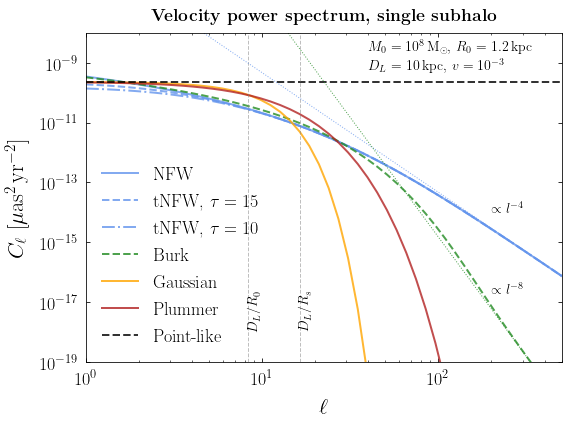

In [195]:
plt.figure(figsize=(8,6))
plt.plot(l_ary, Cl_NFW_ary, label="NFW", alpha=0.8, c='cornflowerblue')
plt.plot(l_ary, Cl_tNFW_ary, label="tNFW, $\\tau = 15$", alpha=0.8, ls='--', c='cornflowerblue')
plt.plot(l_ary, Cl_tNFW2_ary, label="tNFW, $\\tau = 10$", alpha=0.8, ls='-.', c='cornflowerblue')
plt.plot(l_ary, Cl_Burk_ary, label="Burk", alpha=0.8, ls='--',c='forestgreen')
plt.plot(l_ary, Cl_Gauss_ary, label="Gaussian", alpha=0.8, c='orange')
plt.plot(l_ary, Cl_Plummer_ary, label="Plummer", alpha=0.8, color='firebrick')
plt.plot(l_ary, len(l_ary)*[Cl_Point_ary], label="Point-like", c='k', ls='--', alpha=0.8)

plt.axvline((1/(R0/Dl)), c='grey', lw=1, alpha=0.5, ls='--')
plt.text((1/(R0/Dl)),1e-17,'$D_L/R_0$',rotation=90, fontsize=14)

plt.axvline(1/(get_rs_rhos_NFW(1e8*M_s)[0]/Dl), c='grey', lw=1, alpha=0.5, ls='--')
plt.text((1/(get_rs_rhos_NFW(1e8*M_s)[0]/Dl)),1e-17,'$D_L/R_s$',rotation=90, fontsize=14)

n = 4
plt.plot(l_ary, (1/l_ary**n)*Cl_NFW_ary[-1]/(1/(l_ary**n)[-1]), lw=1, alpha=0.8, ls='dotted', c='cornflowerblue')

n = 8
l_base = 2000
fac = 1e69**2*GN**2*v**2*8*mp.pi*l_base**2/Dl**4/(1e-6*asctorad/Year)**2*numerical_Burk(l_base)**2/(1/(l_base**n))

plt.plot(l_ary, (1/l_ary**n)*fac, lw=1, alpha=0.8, ls='dotted',c='forestgreen')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$ [$\mu$as$^2$\,yr$^{-2}$]")


plt.xlim(l_min, l_max)
plt.ylim(1e-19,1e-8)

plt.title('\\textbf{Velocity power spectrum, single subhalo}', fontsize=17.5, y=1.02)
plt.text(40, 2.3e-9,'$M_0 = 10^8\,$M$_\odot$, $R_0$ = ' + str(R0/kpc)[:3] + '\,kpc', fontsize=14)
plt.text(40, 5e-10,'$D_L$ = 10\,kpc, $v=10^{-3}$', fontsize=14)

plt.text(200, 1e-14,'$\propto l^{-4}$', fontsize=14)
plt.text(200, 2e-17,'$\propto l^{-8}$', fontsize=14)

plt.legend(frameon=False)

plt.tight_layout()
plt.savefig("single_sub.pdf")

# Compact object estimates

In [77]:
def rho_nfw(r):
    """Unnormalized NFW profile density"""
    r_s = 18*kpc
    return 1/((r/r_s)*(1+r/r_s)**2)

def rho_v(v):
    """Unnormalized SHM Maxwellian"""
    v0 = 220*Kmps
    if v > 550*Kmps: return 0
    return np.exp(-v**2/v0**2)

def rho_m(m, alpha=1.9):
    return m**-alpha

Rsun = 8*kpc
Rmin = 1*kpc
Rmax = 200*kpc
M_min = 1e6*M_s
M_max = 1e10*M_s

In [78]:
v0 = 220.*Kmps
vesc = 544.*Kmps
vsun = (11.*Kmps, 12.*Kmps + v0, 7.*Kmps)

Nesc = erf(vesc/v0) - 2/np.sqrt(np.pi)*vesc/v0*np.exp(-vesc**2/v0**2)

def fG(vvec):
    v = np.linalg.norm(vvec)
    return 1/(Nesc*np.pi**1.5*v0**3)*np.exp(-v**2/v0**2)*(v < vesc)

In [9]:
DM_frac = 1

In [10]:
# N_halos = DM_frac*1/(m_avg/(1e12*M_s))

In [88]:
norm1 = nquad(lambda l, theta: rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta))), [[Rmin,Rmax],[0,2*np.pi]])[0]

In [99]:
l_min = 50
l_max = 1000
l_ary = np.arange(l_min, l_max)

In [100]:
m = 1e8*M_s

N_halos = DM_frac*1/(m/(1e12*M_s))


In [101]:
conv = np.array(len(l_ary)*[nquad(lambda l, theta: Cl_Point(1., m, l, 1, 1, 2)[0] / (1e-6*asctorad/Year)**2  * rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta))), [[Rmin,Rmax],[0,2*np.pi]])])

In [102]:
# conv = [nquad(lambda l, theta, m: Cl_Point(R0(m), m, l, 1, l_lo, l_lo+1)[0] / (1e-6*asctorad/Year)**2  * rho_m(m) * rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta))), [[Rmin,Rmax],[0,2*np.pi],[M_min,M_max]]) for l_lo in tqdm_notebook(range(l_min, l_max))]

In [103]:
# integ, err = nquad(lambda v, theta, phi: v**4*np.sin(theta)*fG(v*np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]) + vsun),
#       [[0,950.*Kmps],[0,np.pi],[0,2*np.pi]])
# v_term = integ
# print(v_term)

In [90]:
def vproj(v, theta, phi, thetap, phip):
    v_vec = v*np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    theta_hat = np.array([np.cos(thetap)*np.cos(phip), np.cos(thetap)*np.sin(phip), -np.sin(thetap)])
    phi_hat = [-np.sin(phip), np.cos(phip), 0]
    return np.sqrt(np.dot(v_vec,theta_hat)**2 + np.dot(v_vec,phi_hat)**2)

In [91]:
thetap, phip = np.pi/23., np.pi/5.
integ, err = nquad(lambda v, theta, phi: v**2*(vproj(v, theta, phi, thetap, phip))**2*np.sin(theta)*fG(v),
      [[0,950.*Kmps],[0,np.pi],[0,2*np.pi]])
v_term = integ
print(v_term)

5.232258798668646e-07


In [106]:
l_ary = np.arange(l_min, l_max)

sigma_mu = 10 # in muas/yr
N0 = 0.0001e9*4*np.pi
N_l = np.ones_like(l_ary)*sigma_mu**2/N0

In [107]:
C_l = N_halos*np.array(conv)[:,0] / norm1 * v_term # / norm2

In [108]:
# plt.plot(C_l, label='signal')
# plt.plot(N_l, label='noise')

# plt.xscale("log")
# plt.yscale("log")

# plt.legend()

In [97]:
def cov_mat(ell, C_l, N_l, fsky=1):
    return 1/((2*ell+1)*fsky)*(2*(C_l + N_l)**2)

def likelihood(C_l_data, C_l_theta, cov_mat_theta):
    dC_l_theta = np.sqrt(cov_mat_theta)
    return np.sum(-0.5*((C_l_data - C_l_theta)/dC_l_theta)**2)

In [98]:
def find_limit(frac_scale, LL_ary):
    LL_ary *= 2
    for iLL, LL in enumerate(LL_ary):
        if LL < -2.71:
            scale = (LL_ary[iLL-1]+2.71)/(LL_ary[iLL-1]-LL_ary[iLL])
            lim = 10**(np.log10(frac_scale[iLL-1])+scale*(np.log10(frac_scale[iLL])-np.log10(frac_scale[iLL-1])))
            return lim

In [111]:
# LL=[]
# frac_scale = np.logspace(-4,2,100)
# for i in frac_scale:
#     LL.append(2*likelihood(N_l, i*C_l + N_l, cov_mat(l_ary, i*C_l, N_l)))
    
# plt.plot(frac_scale, LL)
# plt.xscale("log")
# plt.ylim(-5,5)

In [112]:
l_ary = np.arange(l_min, l_max)

sigma_mu = 1 # in muas/yr
N0 = 0.0001e9*4*np.pi
N_l = np.ones_like(l_ary)*sigma_mu**2/N0

In [113]:
M_ary = np.logspace(2, 10, 300)*M_s
lim_ary_worse = []
for M in M_ary:
    LL=[]
    frac_scale = np.logspace(-20,1,500)
    for i in frac_scale:
        LL.append(2*likelihood(N_l, i*(M/(m))**1*C_l + N_l, cov_mat(l_ary, i*C_l, N_l)))
    limit = find_limit(frac_scale, LL)
    if limit is not None and limit < 1:
        lim = (limit)
    else:
        lim = (1)
    lim_ary_worse.append(lim)

In [114]:
l_ary = np.arange(l_min, l_max)

sigma_mu = 1 # in muas/yr
N0 = 0.01e9*4*np.pi
N_l = np.ones_like(l_ary)*sigma_mu**2/N0

In [115]:
M_ary = np.logspace(2, 10, 300)*M_s
lim_ary = []
for M in M_ary:
    LL=[]
    frac_scale = np.logspace(-20,1,500)
    for i in frac_scale:
        LL.append(2*likelihood(N_l, i*(M/(m))**1*C_l + N_l, cov_mat(l_ary, i*C_l, N_l)))
    limit = find_limit(frac_scale, LL)
    if limit is not None and limit < 1:
        lim = (limit)
    else:
        lim = (1)
    lim_ary.append(lim)

In [116]:
# ! tlmgr install type1cm

Text(0.5, 0, '$M$ [M$_\\odot$]')

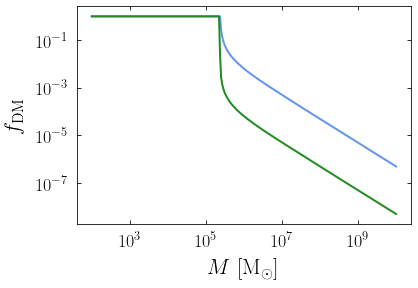

In [117]:
plt.plot(M_ary/M_s, lim_ary_worse)
plt.plot(M_ary/M_s, lim_ary)

plt.xscale("log")
plt.yscale("log")

# plt.xlim(1e4, 1e9)
# plt.ylim(1e-9,1.1)

plt.ylabel("$f_\mathrm{DM}$")
plt.xlabel("$M$ [M$_\odot$]")

# LCDM

In [79]:
l_min = 20
l_max = 200
l_ary = np.arange(l_min, l_max)

In [80]:
def rho_m(m, alpha=1.9):
    return m**-alpha

Rsun = 8*kpc
Rmin = 1*kpc
Rmax = 200*kpc
M_min = 1e5*M_s
M_max = 1e10*M_s

In [81]:
R0 = lambda M: 1.2*kpc*(M/(1e8*M_s))**0.5 # "Concentration"-mass relation from 1711.03554

In [82]:
DM_frac = 0.2

In [83]:
norm2 = quad(lambda m: rho_m(m), M_min, M_max)[0]

In [84]:
m_avg = quad(lambda m: m*rho_m(m), M_min, M_max)[0]/norm2

In [85]:
N_halos = DM_frac*1/(m_avg/(1e12*M_s))

In [86]:
conv = [nquad(lambda l, theta, m: Cl_Plummer(R0(m), m, l, 1, l_lo, l_lo+1)[0] / (1e-6*asctorad/Year)**2  * rho_m(m) * rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta))), [[Rmin,Rmax],[0,2*np.pi],[M_min,M_max]]) for l_lo in tqdm_notebook(range(l_min, l_max))]

In [92]:
C_l = N_halos*np.array(conv)[:,0] / norm1 * v_term / norm2

In [93]:
np.shape(conv)

In [94]:
# plt.plot(l_ary, C_l)
# plt.yscale("log")
# plt.xscale("log")

In [95]:
sigma_mu = 1 # in muas/yr
N0 = 0.01e9*4*np.pi

sig_ary = np.zeros((100,100))

sig_list = np.linspace(0.5, 15, 100)
N_list = np.logspace(6, 9.5, 100)


In [99]:
for isig, sigma_mu in enumerate(tqdm_notebook(sig_list)):
    for iN, N0 in enumerate(N_list):
    
        N_l = np.ones_like(l_ary)*sigma_mu**2/N0

        LL=[]
        frac_scale = np.logspace(-4,2,100)
        for i in frac_scale:
            LL.append(2*likelihood(C_l + N_l, i*C_l + N_l, cov_mat(l_ary, i*C_l, N_l)))
        sig_ary[isig, iN] = np.sqrt(2*(np.max(LL) - LL[0]))
# plt.plot(frac_scale, LL)
# plt.xscale("log")
# plt.ylim(-50,5)

In [100]:
levels = [1,3,5]
X, Y = np.meshgrid(np.log10(N_list), sig_list)

In [101]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 5

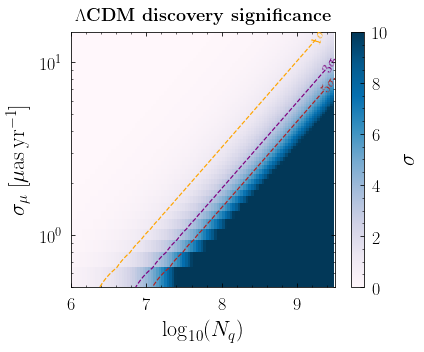

In [103]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, sig_ary, levels = levels, linestyles='--', colors=['orange', 'purple', 'firebrick'], linewidths=1.2)

fmt = {}
strs = ['1$\sigma$', '3$\sigma$', '5$\sigma$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
im = ax.imshow(sig_ary, vmin=0., vmax=10, cmap = 'PuBu', extent=[6,9.5, 0.5,15], aspect='auto', origin='lower')

ax.clabel(CS, fmt=fmt,inline=1, fontsize=14)

# ax.scatter(8, 1)
# ax.scatter(6, 10)

ax.set_xlim(6,9.5)
ax.set_ylim(0.5,15)

ax.set_xlabel("$\log_{10}(N_q)$")
ax.set_ylabel("$\sigma_\mu~[\mu$as\,yr$^{-1}$]")

ax.set_yscale("log")

ax.set_title('\\textbf{$\Lambda$CDM discovery significance}', y = 1.02, fontsize=18)

cbar = fig.colorbar(im)
cbar.set_label('$\sigma$')

plt.tight_layout()
plt.savefig("LCDM_disc.pdf")